In [1]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', '..')))

import src.graphs_generation as graphs_generation
# from src.input_transforms import imageNet_transform

# Stimulus visualization:

Visualization of single stimulus to make sure it is created correctly:

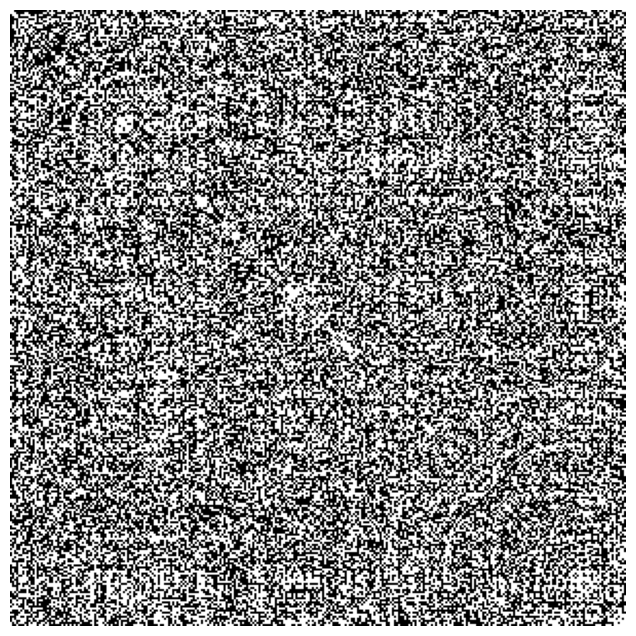

In [2]:
# visualizing input for graph of 160 nodes and clique of 70, "p_increase"
no_resize_graph = graphs_generation.generate_batch(1, 300, [90], "p_reduce", False, p_clique=1)[0]
# visualizing single image without axes:
plt.figure(figsize=(8, 8))  # Increase the size of the figure
plt.axis('off')  # Remove the axes
plt.imshow(np.squeeze(no_resize_graph), cmap='gray')
plt.show()

# Visualization of task difficulty increase:

Visualization of batch of 6 graphs (all with a planted clique) of varying clique size, to make sure the difficulty is appropriately modulated during training

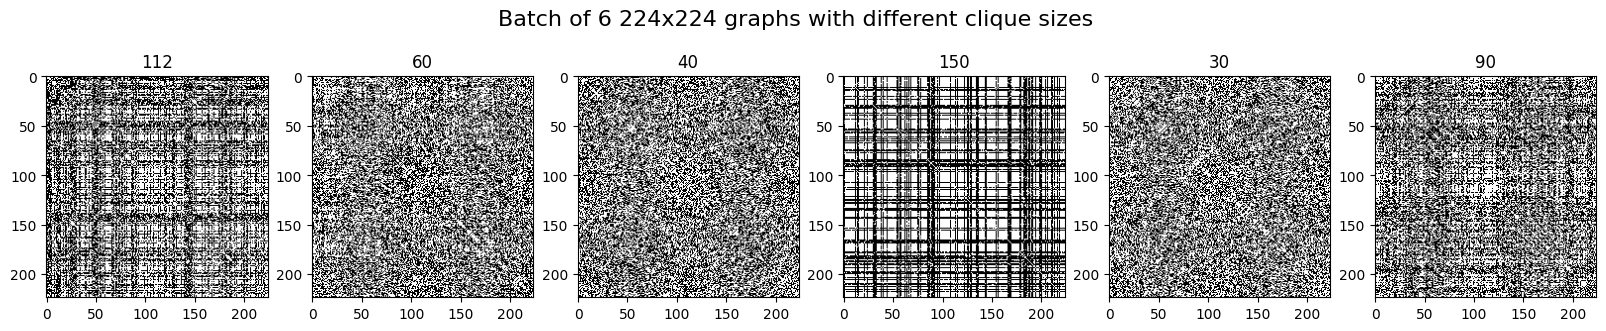

In [3]:
clique_size_array = [112, 60, 40, 150, 30, 90]

graph_batch = graphs_generation.generate_batch(6, 224, clique_size_array, "p_reduce", p_clique=1)

# visualizing grid of graphs
n_plots = graph_batch[0].shape[0]
# - Create a figure with appropriate number of subplots
fig, axs = plt.subplots(1, n_plots, figsize=(20, 5))

# - Iterate over the graphs and add them in the right position
for i, graph in enumerate(graph_batch[0]):
    
    # Plot the graph
    axs[i].imshow(graph.squeeze(), cmap="gray")
    # Set the clique size as title
    axs[i].set_title(clique_size_array[i])

# Set general title:
plt.suptitle("Batch of 6 224x224 graphs with different clique sizes", fontsize=16, y=0.85)

# plt.tight_layout()

plt.show()

# Visualization of alternative p-corrections:

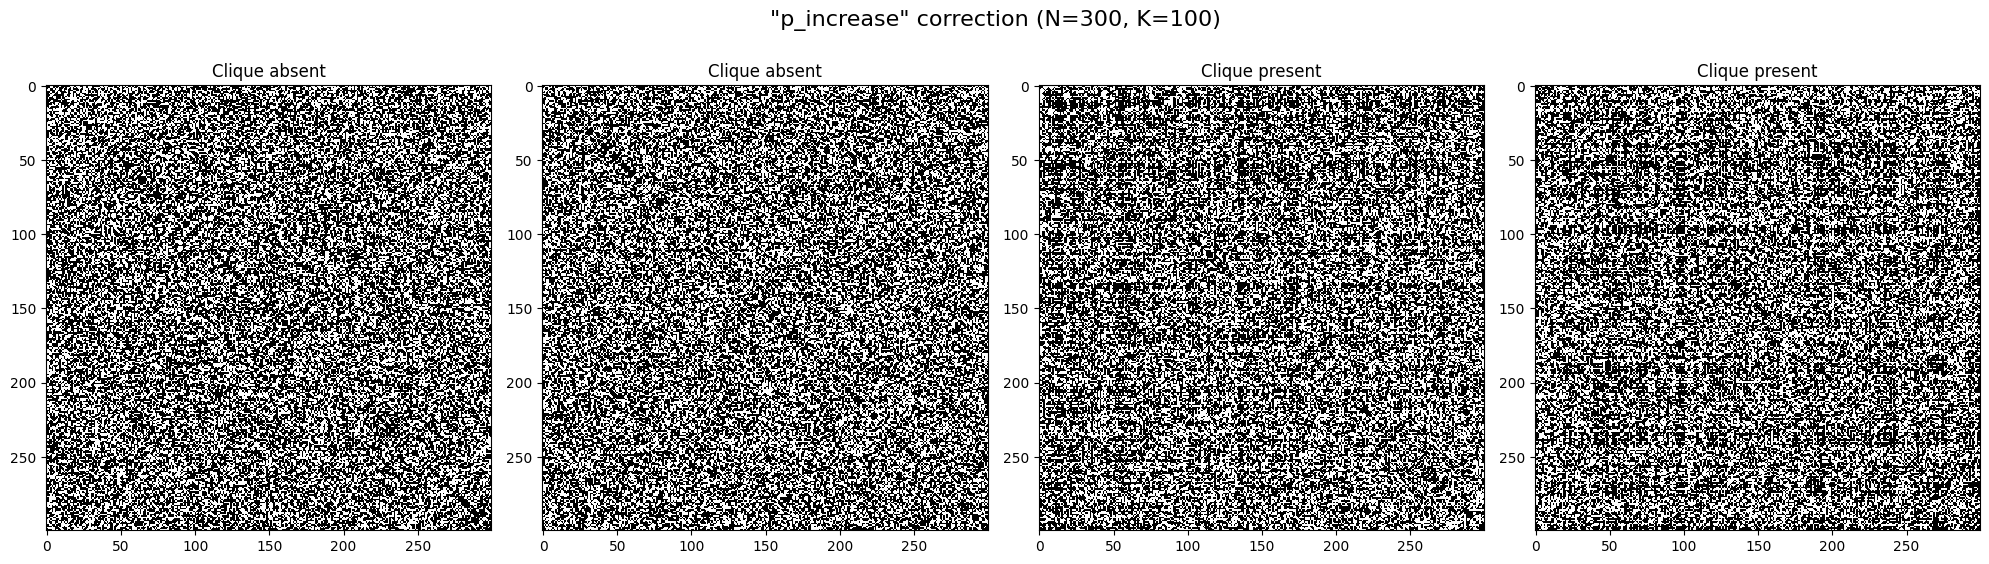

In [6]:
p_correction_type = "p_increase" # "p_reduce" or "p_increase"

clique_size_array = [100, 100, 100, 100]

graph_batch = graphs_generation.generate_batch(4, 300, clique_size_array, p_correction_type)

# visualizing grid of graphs
n_plots = graph_batch[0].shape[0]
# - Create a figure with appropriate number of subplots
fig, axs = plt.subplots(1, n_plots, figsize=(20, 8))

# - Iterate over the graphs and add them in the right position
for i, graph in enumerate(graph_batch[0]):
    
    # Plot the graph
    custom_cmap = ListedColormap(['white', 'black'])  # Map 0 to blue and 1 to yellow
    axs[i].imshow(graph.squeeze(), cmap=custom_cmap)
    # Set the clique size and the presence or absence of the clique as title
    if graph_batch[1][i] == 1:
        title = "Clique present"
    elif graph_batch[1][i] == 0:
        title = "Clique absent"
    else:
        raise ValueError("Invalid clique presence value: must be 0 or 1")        
    axs[i].set_title(title)

# Set general title:
plt.suptitle(f'"{p_correction_type}" correction (N=300, K={clique_size_array[0]})', fontsize=16, y=0.85)

plt.tight_layout()

plt.show()